<a href="https://colab.research.google.com/github/akshziitj/GNN_for_EHR/blob/master/gnn_ehr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNN for EHR: Patient Clustering Demo

This notebook demonstrates a complete workflow for clustering patients based on their EHR (Electronic Health Record) codes. It includes:
1.  **Setup**: Installing libraries and checking the environment.
2.  **Data Generation**: Creating a synthetic patient-code dataset.
3.  **Data Exploration**: Calculating basic statistics.
4.  **TF-IDF Baseline**: Running a standard machine learning baseline (TF-IDF + KMeans) and evaluating its Silhouette score.
5.  **GNN Model**: Building, training, and generating embeddings using a Graph Attention Network (GATv2).
6.  **GNN Evaluation**: Evaluating the GNN embeddings with KMeans and its Silhouette score.
7.  **Analysis & Visualization**: Visualizing the results using t-SNE, heatmaps, and neighbor analysis.

## 1. Environment Setup

### 1.1. Check GPU and Clone Repository

We'll start by checking for a GPU, cloning the `GNN_for_EHR` repository, and navigating into its directory.

In [1]:
!nvidia-smi
!rm -rf GNN_for_EHR
!git clone https://github.com/NYUMedML/GNN_for_EHR.git
%cd GNN_for_EHR

Wed Nov  5 10:10:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 1.2. Install Dependencies

Install the required libraries, primarily PyTorch and PyTorch Geometric (PyG).

In [2]:
# Install PyTorch with CUDA 12.1 wheels
!pip install --quiet --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Core PyG. Start minimal.
!pip install --quiet torch_geometric

# Optional: compiled extensions (faster, sometimes required)
!pip install --quiet \
  pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv \
  -f https://data.pyg.org/whl/torch-2.4.0+cu121.html

### 1.3. Verify Installations

Check that PyTorch and PyG are installed correctly and that CUDA is available.

In [3]:
import torch, torch_geometric
print("Torch:", torch.__version__, "CUDA:", torch.version.cuda, "CUDA available:", torch.cuda.is_available())
print("PyG:", torch_geometric.__version__)

/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/libpyg.so: undefined symbol: _ZNK5torch8autograd4Node4nameEv
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_g

Torch: 2.8.0+cu126 CUDA: 12.6 CUDA available: True
PyG: 2.7.0


## 2. Synthetic Data Generation

This cell generates a toy corpus of 500 patients and 120 ICD-like codes. The data is structured with co-morbidity blocks (e.g., metabolic, cardiac, respiratory) to mimic real-world EHR data patterns. The generated data is saved to `data/sample/`.

In [4]:
import os, json, random, numpy as np, pathlib

pathlib.Path("data/sample").mkdir(parents=True, exist_ok=True)

# Toy corpus: 500 patients, 120 ICD-like codes. Co-morbidity blocks to create structure.
rng = np.random.default_rng(7)
num_pat=500; num_codes=120

# Blocks: metabolic(0-19), cardiac(20-39), respiratory(40-59), neuro(60-79), misc(80-119)
blocks = [(0,20),(20,40),(40,60),(60,80),(80,120)]
patients = {}
labels = {}  # binary outcome just for demo

for pid in range(num_pat):
    # pick a dominant block
    b = rng.integers(0,4)
    a,bhi = blocks[b]
    # sample 3–7 codes from dominant + 0–3 from others
    k_dom = rng.integers(3,8)
    codes = rng.choice(np.arange(a,bhi), size=k_dom, replace=False).tolist()
    for _ in range(rng.integers(0,4)):
        ob = rng.integers(0,5)
        oa,ohi = blocks[ob]
        codes += rng.choice(np.arange(oa,ohi), size=rng.integers(1,3), replace=False).tolist()
    codes = sorted(set(codes))
    patients[str(pid)] = [int(c) for c in codes]
    # synthetic outcome: higher risk if cardiac+metabolic present
    labels[str(pid)] = int(any(20<=c<40 for c in codes) and any(0<=c<20 for c in codes))

with open("data/sample/patient_to_codes.json","w") as f:
    json.dump(patients, f)

with open("data/sample/labels.json","w") as f:
    json.dump(labels, f)

print("Patients:", len(patients), "Example:", list(patients.items())[:2])
print("Positives:", sum(labels.values()))


Patients: 500 Example: [('0', [64, 69, 70, 73, 74, 75]), ('1', [21, 25, 26, 27, 31, 34, 35, 49, 59, 66, 71])]
Positives: 89


## 3. Data Exploration

Load the generated data to calculate and print key statistics: total number of patients, number of unique codes, and the average number of codes per patient.

In [5]:
import json
import numpy as np

# Load the generated data
with open("data/sample/patient_to_codes.json", "r") as f:
    p2c = json.load(f)

# Calculate stats
num_patients = len(p2c)
all_codes = [code for codes in p2c.values() for code in codes]
num_unique_codes = len(set(all_codes))
total_codes = sum(len(codes) for codes in p2c.values())
average_codes = total_codes / num_patients

print(f"Number of patients: {num_patients}")
print(f"Number of unique ICD codes: {num_unique_codes}")
print(f"Average codes per patient: {average_codes:.2f}")

Number of patients: 500
Number of unique ICD codes: 120
Average codes per patient: 7.22


## 4. Baseline Model: TF-IDF + KMeans

This cell implements a standard machine learning baseline. It treats each patient's list of codes as a document, applies TF-IDF vectorization, and then performs KMeans clustering. Finally, it calculates the Silhouette score to evaluate the quality of the clusters.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import json
import numpy as np

# Load patient->codes
with open("data/sample/patient_to_codes.json") as f:
    p2c = json.load(f)

# Convert codes to string format for TF-IDF
patient_docs = [" ".join(map(str, codes)) for codes in p2c.values()]

# Initialize and fit TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(patient_docs)

# Perform KMeans clustering (using 5 clusters as in the GNN example)
kmeans_tfidf = KMeans(n_clusters=5, n_init=10, random_state=0)
kmeans_tfidf.fit(X_tfidf)
labels_tfidf = kmeans_tfidf.labels_

# Calculate and print Silhouette score
sil_tfidf = silhouette_score(X_tfidf, labels_tfidf)
print(f"TF-IDF KMeans Silhouette Score: {sil_tfidf:.3f}")

TF-IDF KMeans Silhouette Score: 0.071


## 5. GNN Model: Training & Embedding Generation

This cell builds and trains the Graph Neural Network (GNN) model.

1.  **Graph Construction**: It builds a graph where nodes are disease codes. Edges are created between codes that co-occur in patient records, weighted by Positive Pointwise Mutual Information (PMI) to capture meaningful relationships.
2.  **Model Definition**: A `GATv2Conv` (Graph Attention Network) model is defined.
3.  **Unsupervised Training**: The model is trained using an unsupervised objective. It tries to pull the embeddings of connected (co-occurring) nodes closer together, weighted by their PMI score.
4.  **Embedding Generation**:
    * `disease_embeddings.npy`: The trained GNN generates embeddings for each disease code.
    * `patient_embeddings.npy`: Patient embeddings are created by taking a weighted average of the embeddings of the diseases they have. The weight is based on a simple heuristic (L2 norm of the disease embedding, passed through a softmax) to give more importance to more "significant" disease embeddings.

In [7]:
import json, numpy as np, torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv
from itertools import combinations
import os
import torch.nn.functional as F
from collections import Counter, defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load patient->codes (already in memory as p2c)
with open("data/sample/patient_to_codes.json") as f:
    p2c = json.load(f)

num_codes = max(c for codes in p2c.values() for c in codes) + 1

# Build co-occurrence edges and PMI weights
code_freq = Counter()
pair_freq = Counter()
num_pat = len(p2c)

for codes in p2c.values():
    codes = sorted(set(codes))
    for c in codes:
        code_freq[c]+=1
    for i,j in combinations(codes,2):
        pair = (i,j) if i<j else (j,i)
        pair_freq[pair]+=1

edges_i, edges_j, weights = [], [], []
for (i,j), n_ij in pair_freq.items():
    p_ij = n_ij/num_pat
    p_i = code_freq[i]/num_pat
    p_j = code_freq[j]/num_pat
    pmi = np.log((p_ij + 1e-9)/(p_i*p_j + 1e-12))
    if pmi>0:
        edges_i += [i,j]
        edges_j += [j,i]
        w = float(pmi)
        weights += [w,w]

edge_index = torch.tensor([edges_i, edges_j], dtype=torch.long)
edge_weight = torch.tensor(weights, dtype=torch.float)

x = nn.Embedding(num_codes, 64).weight.detach()
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight).to(device)

class GATModel(nn.Module):
    def __init__(self, in_dim=64, hid=128, out_dim=64, heads=4, dr=0.3):
        super().__init__()
        self.lin = nn.Linear(in_dim, in_dim)
        self.g1 = GATv2Conv(in_dim, hid//heads, heads=heads, dropout=dr)
        self.g2 = GATv2Conv(hid, out_dim//heads, heads=heads, dropout=dr, concat=True)
        self.act = nn.ELU()
        self.dr = nn.Dropout(dr)
    def forward(self, x, edge_index):
        x = self.lin(x)
        x = self.dr(self.act(self.g1(x, edge_index)))
        x = self.g2(x, edge_index)
        return x

model = GATModel().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-5)

print(f"Training GNN on {device}...")
model.train()
for epoch in range(50):
    opt.zero_grad()
    z = model(data.x, data.edge_index)
    # Unsupervised objective: pull connected nodes together (weighted)
    i,j = data.edge_index
    loss = ((z[i]-z[j]).pow(2).sum(1) * edge_weight.to(device)).mean()
    loss.backward()
    opt.step()
    if epoch%10==0:
        print(f"epoch {epoch} loss {loss.item():.4f}")

emb = model(data.x, data.edge_index).detach().cpu().numpy()
np.save("disease_embeddings.npy", emb)

# Patient embeddings: attention-weighted mean with simple learned scorer
w = nn.Parameter(torch.zeros(emb.shape[1]))
with torch.no_grad():
    # score = w^T h; start with uniform since w=0
    pass

pvecs = {}
for pid, codes in p2c.items():
    if not codes:
        continue
    H = torch.tensor(emb[codes], dtype=torch.float)
    # softmax over L2 norm as heuristic importance
    scores = torch.linalg.norm(H, dim=1)
    alpha = F.softmax(scores, dim=0).unsqueeze(1)
    hp = (alpha*H).sum(0).numpy()
    pvecs[pid] = hp

np.save("patient_embeddings.npy", pvecs)
print("Saved: disease_embeddings.npy, patient_embeddings.npy")

Training GNN on cuda...
epoch 0 loss 0.1072
epoch 10 loss 0.0349
epoch 20 loss 0.0204
epoch 30 loss 0.0137
epoch 40 loss 0.0107
Saved: disease_embeddings.npy, patient_embeddings.npy


## 6. GNN Model: Evaluation (Clustering)

This cell loads the `patient_embeddings.npy` file generated by the GNN, performs KMeans clustering (with 5 clusters, same as the baseline), and reports the Silhouette score. This allows for a direct comparison with the TF-IDF baseline.

In [8]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load patient embeddings
pmap = np.load("patient_embeddings.npy", allow_pickle=True).item()
X_gnn = np.vstack(list(pmap.values()))

# Run KMeans
kmeans_gnn = KMeans(n_clusters=5, n_init=10, random_state=0).fit(X_gnn)
labels_gnn = kmeans_gnn.labels_

# Calculate and print Silhouette score
sil_gnn = silhouette_score(X_gnn, labels_gnn)
print(f"GNN KMeans Silhouette Score: {sil_gnn:.3f}")

GNN KMeans Silhouette Score: 0.239


## 7. Analysis & Visualization

Now we use the embeddings and cluster labels to understand the data.

### 7.1. t-SNE of Disease Embeddings

This plot visualizes the `disease_embeddings.npy` in 2D space using t-SNE. We hope to see that codes from the same synthetic block (e.g., all cardiac codes) cluster together.

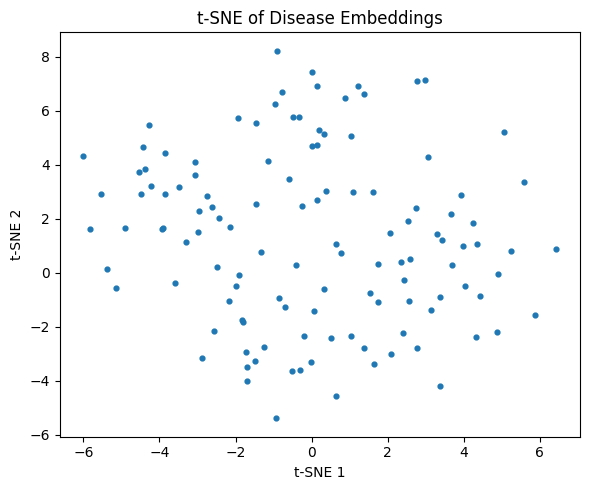

In [9]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

E = np.load("disease_embeddings.npy")              # shape: [num_codes, d]
tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=0)
Z = tsne.fit_transform(E)

plt.figure(figsize=(6,5))
plt.scatter(Z[:,0], Z[:,1], s=12)
plt.title("t-SNE of Disease Embeddings")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.savefig("fig_disease_tsne.png", dpi=300)
plt.show()


### 7.2. t-SNE of Patient Embeddings

This plot visualizes the `patient_embeddings.npy` in 2D space, with each point colored by the cluster ID assigned by KMeans (using the `labels_gnn` from the previous step).

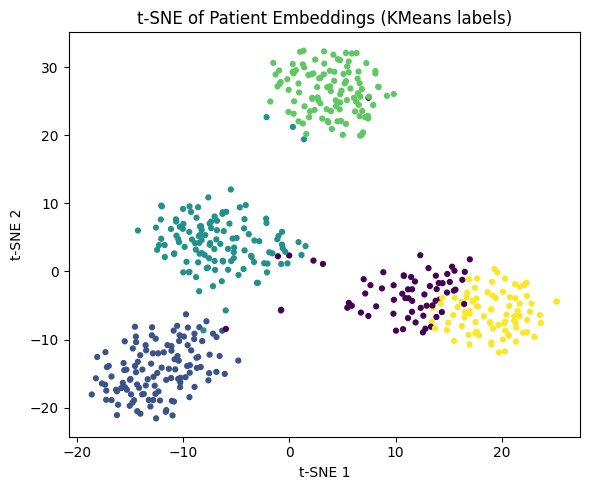

In [10]:
# Note: This cell re-runs KMeans, but we could also use the 'labels_gnn' from cell 6.
# For self-contained visualization, we'll follow the original cell's logic.
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

pe = np.load("patient_embeddings.npy", allow_pickle=True).item()
P_ids = list(pe.keys())
X = np.vstack([pe[k] for k in P_ids])

kmeans = KMeans(n_clusters=5, n_init=10, random_state=0).fit(X)
labels = kmeans.labels_

tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=0)
Zp = tsne.fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(Zp[:,0], Zp[:,1], s=12, c=labels)
plt.title("t-SNE of Patient Embeddings (KMeans labels)")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.savefig("fig_patient_tsne_kmeans.png", dpi=300)
plt.show()


### 7.3. Disease Co-occurrence Subgraph

This visualization constructs a graph based on the raw co-occurrence frequencies (not PMI) and displays the top 50 most frequent co-occurring disease pairs. This helps visualize the raw structure of the data.

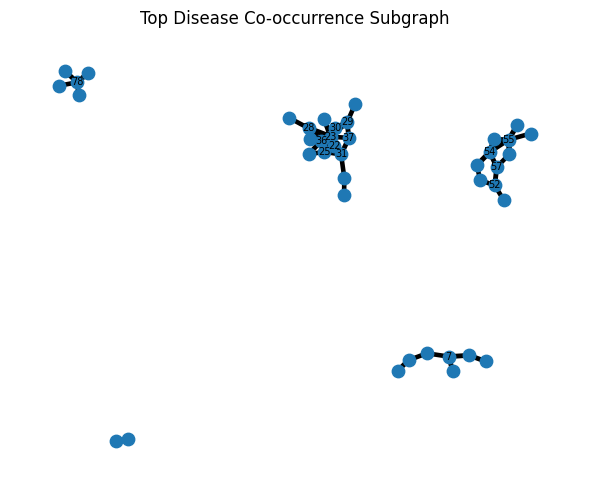

In [11]:
import json, numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

with open("data/sample/patient_to_codes.json") as f:
    p2c = json.load(f)

num_pat = len(p2c)
code_freq = Counter()
pair_freq = Counter()
for codes in p2c.values():
    codes = sorted(set(codes))
    for c in codes: code_freq[c]+=1
    for i,j in combinations(codes,2):
        if i>j: i,j=j,i
        pair_freq[(i,j)]+=1

# keep top 50 edges by frequency
top_pairs = sorted(pair_freq.items(), key=lambda x: x[1], reverse=True)[:50]
G = nx.Graph()
for (i,j), w in top_pairs:
    G.add_edge(i,j,weight=w)

plt.figure(figsize=(6,5))
pos = nx.spring_layout(G, seed=0)
nx.draw_networkx_nodes(G, pos, node_size=80)
nx.draw_networkx_edges(G, pos, width=[0.5+0.2*G[u][v]['weight'] for u,v in G.edges()])
# label only high-degree nodes
deg = dict(G.degree())
lbls = {n:str(n) for n,d in deg.items() if d>=3}
nx.draw_networkx_labels(G, pos, labels=lbls, font_size=7)
plt.title("Top Disease Co-occurrence Subgraph")
plt.axis("off")
plt.tight_layout()
plt.savefig("fig_disease_cooccurrence_graph.png", dpi=300)
plt.show()


### 7.4. Disease & Patient Neighbor Analysis

This cell performs two types of analysis:
1.  **Disease Neighbors**: Finds the top 5 most similar diseases for a few sample diseases (5, 25, 65) based on the cosine similarity of their GNN embeddings.
2.  **Patient Neighbors**: Finds the 5 nearest neighbors for the first 5 patients based on the cosine similarity of their GNN patient embeddings.

In [12]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

emb = np.load("disease_embeddings.npy")
pmap = np.load("patient_embeddings.npy", allow_pickle=True).item()
X = np.vstack(list(pmap.values()))

print("--- Disease Neighbor Analysis (Cosine Similarity) ---")
sim = cosine_similarity(emb)
for idx in [5, 25, 65]:
    # find top 5 neighbors (excluding self)
    nn = sim[idx].argsort()[-6:-1][::-1]
    print(f"Disease {idx} neighbors:", nn)

print("\n--- Patient Neighbor Analysis (k-NN) ---")
nbrs = NearestNeighbors(n_neighbors=5, metric="cosine").fit(X)
dist, ind = nbrs.kneighbors(X[:5])
print("Patient neighbor indices for first 5 rows:\n", ind)

--- Disease Neighbor Analysis (Cosine Similarity) ---
Disease 5 neighbors: [ 6  0  7 56 10]
Disease 25 neighbors: [ 24  28  35  38 101]
Disease 65 neighbors: [ 61  37  71  68 110]

--- Patient Neighbor Analysis (k-NN) ---
Patient neighbor indices for first 5 rows:
 [[  0 443 381 156  97]
 [  1 497 365 112 157]
 [  2  26  32 449   7]
 [  3  23 465 433 481]
 [  4 496 125 355 377]]


### 7.5. Patient-Patient Similarity Heatmap

This visualization shows a heatmap of the cosine similarity matrix for the first 50 patients, giving a dense view of patient similarity.

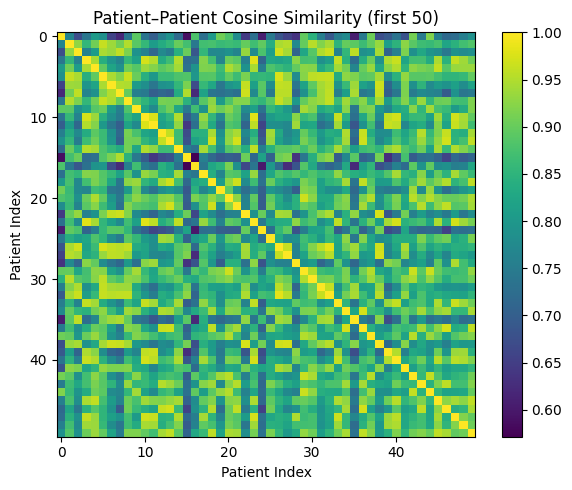

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

pe = np.load("patient_embeddings.npy", allow_pickle=True).item()
X = np.vstack(list(pe.values()))
X50 = X[:50]
S = cosine_similarity(X50)

plt.figure(figsize=(6,5))
plt.imshow(S, aspect="auto")
plt.title("Patient–Patient Cosine Similarity (first 50)")
plt.xlabel("Patient Index"); plt.ylabel("Patient Index")
plt.colorbar()
plt.tight_layout()
plt.savefig("fig_patient_similarity_heatmap.png", dpi=300)
plt.show()


### 7.6. Heuristic Disease Contributions

This plot shows the top 10 diseases contributing to Patient 0's final embedding, based on the heuristic "attention" score (softmax of the L2 norm) used during the patient embedding generation.

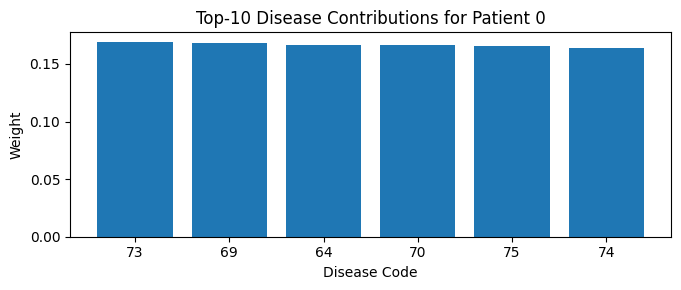

In [14]:
import json, numpy as np, matplotlib.pyplot as plt
pid = "0"  # change as needed

E = np.load("disease_embeddings.npy")
with open("data/sample/patient_to_codes.json") as f:
    p2c = json.load(f)
codes = p2c[pid]

# heuristic "attention": L2 norm of disease embeddings followed by softmax
H = E[codes]
scores = np.linalg.norm(H, axis=1)
alpha = np.exp(scores) / np.sum(np.exp(scores))

order = np.argsort(alpha)[::-1][:10]
top_codes = [str(codes[i]) for i in order]
top_alpha = alpha[order]

plt.figure(figsize=(7,3))
plt.bar(range(len(top_codes)), top_alpha)
plt.xticks(range(len(top_codes)), top_codes, rotation=0)
plt.title(f"Top-10 Disease Contributions for Patient {pid}")
plt.xlabel("Disease Code"); plt.ylabel("Weight")
plt.tight_layout()
plt.savefig("fig_patient_attention_bars.png", dpi=300)
plt.show()


## 8. (Optional) Save Artifacts to Google Drive

This cell mounts Google Drive and copies all generated files (embeddings, figures, data) into a new directory for persistence.

In [15]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p '/content/drive/MyDrive/gnn_ehr_demo'
!cp -r *.npy data/sample *.png '/content/drive/MyDrive/gnn_ehr_demo/' 2>/dev/null || true
print("Copied artifacts to /content/drive/MyDrive/gnn_ehr_demo/")

Mounted at /content/drive
Copied artifacts to /content/drive/MyDrive/gnn_ehr_demo/
